In [38]:
%matplotlib inline
import itertools
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import pickle
from scipy.optimize import curve_fit

In [39]:
# Define a function to deserialize the data
def deserialize(name, folder_name):
    with open(os.path.join(folder_name, name + ".pkl"), 'rb') as f:
        data = pickle.load(f, encoding='latin1', fix_imports=True)
    return data

In [40]:
test_size = 9216
test_path = 'samples/test_data_f3_plain_' + str(test_size) + '/'

# Training and Testing samples
x_test, y_test = deserialize("x_test", test_path), deserialize("y_test", test_path)

In [41]:
archs = [(6, 1), (7, 1), (12, 1), (17, 1), (22, 1), (27, 1), (32, 1),
    (6, 2), (8, 2), (10, 2), (12, 2), (14, 2), (16, 2),
    (6, 3), (8, 3), (10, 3)]

X = x_test.detach().numpy()

sampling_method = 'SOB'

if sampling_method == 'REG':
    color = 'darkolivegreen'
elif sampling_method == 'UNI':
    color = 'firebrick'
elif sampling_method == 'SOB':
    color = 'violet'

net_err = []
net_out = []
net_dist = []

for width, depth in archs:
        for state in ['plain', 'hole']:
            path = "serialized_" + state + "/serialized_data_" + sampling_method
            for test_num in range(1, 9):
                # Deserialize the data using pickle
                folder_name = path + f"_{width}_{depth}_{test_num}"
                list_names = ["mean_dist", "num_out", "output_test", "gensample_err"]
                list_data = []
                for name in list_names:
                    list_data.append(deserialize(name, folder_name))
                mean_dist = np.array(list_data[0])
                num_out = np.array(list_data[1])
                output_test = list_data[2].detach().numpy()
                gen_err = np.array(list_data[3])

                if state == 'plain':
                    # create a boolean mask based on your conditions
                    mask = np.logical_or.reduce([ (-2 <= X[:, 0]) & (X[:, 0] <= 2) & (-2 <= X[:, 1]) & (X[:, 1] <= -1),
                                                (-2 <= X[:, 0]) & (X[:, 0] <= -1) & (-1 <= X[:, 1]) & (X[:, 1] <= 2),
                                                (-2 <= X[:, 0]) & (X[:, 0] <= 2) & (1 <= X[:, 1]) & (X[:, 1] <= 2),
                                                (1 <= X[:, 0]) & (X[:, 0] <= 2) & (-1 <= X[:, 1]) & (X[:, 1] <= 1)
                                                ])
                else:
                    mask = np.logical_or((-2 <= X[:, 0]) & (X[:, 0] <= -0.667) & (0.667 <= X[:, 1]) & (X[:, 1] <= 2),
                                        (0.667 <= X[:, 0]) & (X[:, 0] <= 2) & (-0.667 <= X[:, 1]) & (X[:, 1] <= 0.667),
                                        (-2 <= X[:, 0]) & (X[:, 0] <= -0.667) & (-2 <= X[:, 1]) & (X[:, 1] <= -0.667))
                
                avg_err = sum(gen_err[mask]) / len(gen_err[mask])
                avg_out = sum(num_out[mask]) / len(num_out[mask])
                avg_dist = sum(mean_dist[mask]) / len(mean_dist[mask])
                
                net_err.append(avg_err)
                net_dist.append(avg_dist)
                net_out.append(avg_out)

Slope (a): 0.02623952206415862
Intercept (b): 1.0654345545861172
3.8151595504195592 1.2139242739400156 1.1655425177876362


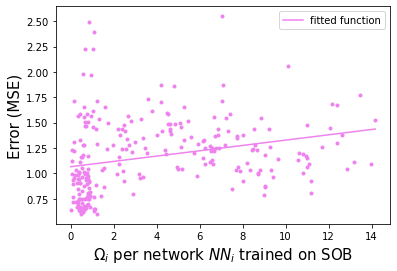

In [42]:
# calculate polynomial
z_dist = np.polyfit(net_out, net_err, 1)
f_dist = np.poly1d(z_dist)
a_dist = z_dist[0] # slope
b_dist = z_dist[1] # intercept

# print coefficients
print("Slope (a):", a_dist)
print("Intercept (b):", b_dist)

# calculate new x's and y's
x_dist = np.linspace(min(net_out), max(net_out), 100)
y_dist = f_dist(x_dist)

plt.plot(x_dist, y_dist, label="fitted function", color=color)
plt.plot(net_out, net_err, '.', color=color)

plt.xlabel(r"$\Omega_i$ per network $NN_i$ trained on "+str(sampling_method), fontsize=15)
plt.ylabel("Error (MSE)", fontsize=15)
plt.legend()

plt.savefig(f"images/F3OmegaNet{sampling_method}.png", dpi=300)

tot_out = sum(list(net_out)) / len(list(net_out))
tot_dist = sum(list(net_dist)) / len(list(net_dist))
tot_err = sum(list(net_err)) / len(list(net_err))
print(tot_out, tot_dist, tot_err)

Slope (a): 0.41303561487666657
Intercept (b): 0.6641485588871113
3.8151595504195592 1.2139242739400156 1.1655425177876362


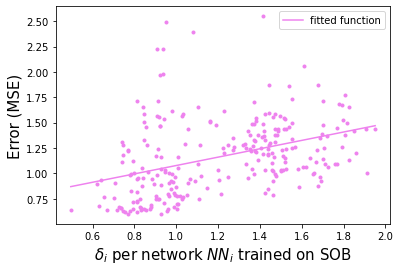

In [43]:
# calculate polynomial
z_dist = np.polyfit(net_dist, net_err, 1)
f_dist = np.poly1d(z_dist)
a_dist = z_dist[0] # slope
b_dist = z_dist[1] # intercept

# print coefficients
print("Slope (a):", a_dist)
print("Intercept (b):", b_dist)

# calculate new x's and y's
x_dist = np.linspace(min(net_dist), max(net_dist), 100)
y_dist = f_dist(x_dist)

plt.plot(x_dist, y_dist, label="fitted function", color=color)
plt.plot(net_dist, net_err, '.', color=color)

plt.xlabel(r"$\delta_i$ per network $NN_i$ trained on "+str(sampling_method), fontsize=15)
plt.ylabel("Error (MSE)", fontsize=15)
plt.legend()

plt.savefig(f"images/F3DeltaNet{sampling_method}.png", dpi=300)

tot_out = sum(list(net_out)) / len(list(net_out))
tot_dist = sum(list(net_dist)) / len(list(net_dist))
tot_err = sum(list(net_err)) / len(list(net_err))
print(tot_out, tot_dist, tot_err)